In [1]:
import torch
import os
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from pylab import rcParams
from PIL import Image

In [2]:
model_dir="runtime-model-50epochs-b64-expdecay-reverseKL"
batch_size=64
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"

## Only In domain dataset evaluation

In [2]:
out_dir=model_dir+"/eval"

In [3]:
cmd = f"python ./priornet/run/eval_ID.py --batch_size {batch_size} --gpu -1 --model_dir {model_dir} --n_channels {num_channels} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python ./priornet/run/eval_ID.py --batch_size 64 --gpu -1 --model_dir runtime-model-50epochs-b64-expdecay --n_channels 1 ./runtime-data MNIST runtime-model-50epochs-b64-expdecay/eval


In [4]:
os.system(cmd)

0

## Both In-domain and OOD dataset evaluation

In [2]:
ood_dataset="OMNIGLOT"
out_dir=model_dir+"/ood-eval"

In [6]:
cmd = f"python ./priornet/run/ood_detect.py --batch_size {batch_size} --gpu -1 --model_dir {model_dir} --n_channels {num_channels} {data_dir} {in_dataset} {ood_dataset} {out_dir}"
print(cmd)

python ./priornet/run/ood_detect.py --batch_size 64 --gpu -1 --model_dir runtime-model-50epochs-b64-expdecay --n_channels 1 ./runtime-data MNIST OMNIGLOT runtime-model-50epochs-b64-expdecay/ood-eval


In [7]:
os.system(cmd)

0

## OOD Detection - confidence

In [3]:
models = ["runtime-model-50epochs-b128-expdecay-reverseKL", "runtime-model-50epochs-b64-expdecay-reverseKL", "runtime-model-50epochs-b64-expdecay"]

In [3]:
def plot_curve(x, y, axes, row_index, col_index, x_label='',y_label=''):
    axis = axes[row_index][col_index]
    right_side = axis.spines["right"]
    right_side.set_visible(False)
    top_side = axis.spines["top"]
    top_side.set_visible(False)
    
    axis.set_title("\n".join(wrap(models[col_index], 20)))
    axis.plot(x, y)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_ylim(0.00, 1.00)
    axis.set_xlim(0.00, 1.00)

In [13]:
def plot_pr_roc_curve_ood(eval_dir, eval_measure):
    aupr_list = []
    auroc_list = []
    rcParams['figure.figsize'] = 15, 10
    figure, axes = plt.subplots(nrows=2, ncols=len(models))
    for i in range(len(models)):
        model_dir = models[i]
        print(f"eval model: {model_dir}")
        id_conf = f"{model_dir}/{eval_dir}/{eval_measure}_id.txt"
        ood_conf = f"{model_dir}/{eval_dir}/{eval_measure}_ood.txt"

        confidence_id = np.loadtxt(id_conf)
        confidence_ood = np.loadtxt(ood_conf)

        # append both type of samples
        scores = np.concatenate((confidence_id, confidence_ood), axis=0)
        scores = np.asarray(scores, dtype=np.float128)
        if eval_measure == 'confidence':
            # negation of confidence is the measure for detecting OOD, ID samples have higher confidence than OOD samples.
            scores *= -1.0
    
        # OOD detection is a Bianry classification task
        truth_labels = np.concatenate((np.zeros_like(confidence_id), np.ones_like(confidence_ood)), axis=0)

        precision, recall, thresholds = precision_recall_curve(truth_labels, scores)
        plot_curve(recall, precision, axes, 0, i, 'Recall', 'Precision')
        aupr = auc(recall, precision)
        aupr_list.append(aupr)

        fpr, tpr, thresholds = roc_curve(truth_labels, scores)
        plot_curve(fpr, tpr, axes, 1, i, 'False Positive', 'True Positive')
        roc_auc = roc_auc_score(truth_labels, scores)
        auroc_list.append(roc_auc)

    figure.tight_layout(pad=2)
    plt.show()
    return aupr_list,auroc_list

In [14]:
def plot_aupr_auroc(aupr_list, auroc_list):
    x = np.arange(len(models)) 
    width = 0.35
    auprs = [np.round(x * 100.0, 1) for x in aupr_list]
    aurocs = [np.round(x * 100.0, 1) for x in auroc_list]

    rcParams['figure.figsize'] = 5, 5
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, auprs, width, label='AU_PR')
    rects2 = ax.bar(x + width/2, aurocs, width, label='AU_ROC')

    ax.set_ylabel('AC')
    ax.set_title('AC by different models')
    ax.set_xticks(x)
    ax.set_xticklabels(['model1','model2','model3'])
    ax.legend()

    fig.tight_layout()
    plt.show()

eval model: runtime-model-50epochs-b128-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay


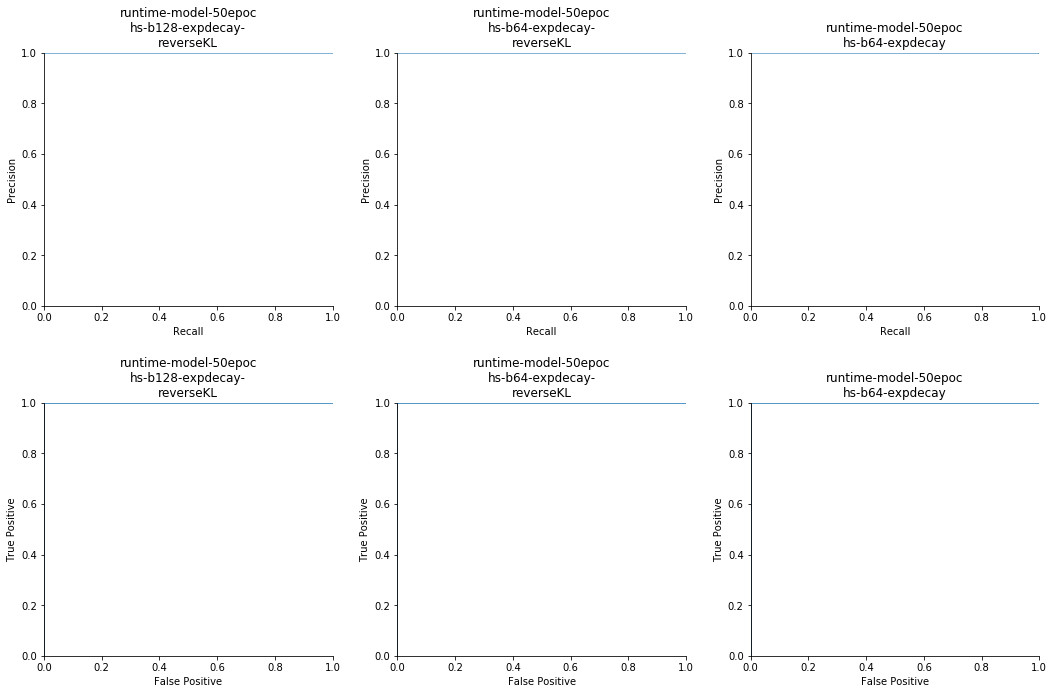

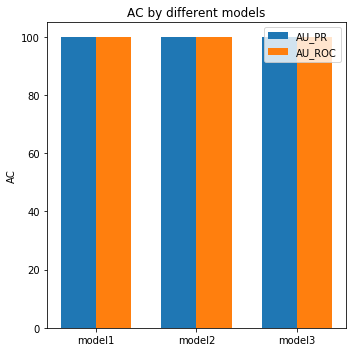

In [15]:
aupr_list, auroc_list = plot_pr_roc_curve_ood('ood-eval', 'confidence')
plot_aupr_auroc(aupr_list, auroc_list)

## Misclassification Detection - confidence

In [16]:
def plot_pr_roc_curve_misclassify(eval_dir, eval_measure):
    aupr_list = []
    auroc_list = []
    class_dist = []
    rcParams['figure.figsize'] = 15, 10
    figure, axes = plt.subplots(nrows=2, ncols=len(models))
    for i in range(len(models)):
        model_dir = models[i]
        print(f"eval model: {model_dir}")
        evalmeasure = f"{model_dir}/{eval_dir}/{eval_measure}.txt"

        measure = np.loadtxt(evalmeasure)

        scores = measure 
        if eval_measure == 'confidence':
            # negation needed for confidence, as confidence is indicator of -ve samples for correct classified samples
            # we need scores for misclassified samples to be higher, so we negate.
            scores *= -1.0

        # Misclassification is a Bianry classification task
        probs = np.loadtxt(f"{model_dir}/{eval_dir}/probs.txt")
        labels = np.loadtxt(f"{model_dir}/{eval_dir}/labels.txt")
        class_preds = np.argmax(probs, axis=1)
        
        truth_labels = np.asarray(labels != class_preds, dtype=np.int32)

        precision, recall, thresholds = precision_recall_curve(truth_labels, scores)
        plot_curve(recall, precision, axes, 0, i, 'Recall', 'Precision')
        aupr = auc(recall, precision)
        aupr_list.append(aupr)

        fpr, tpr, thresholds = roc_curve(truth_labels, scores)
        plot_curve(fpr, tpr, axes, 1, i, 'False Positive', 'True Positive')
        roc_auc = roc_auc_score(truth_labels, scores)
        auroc_list.append(roc_auc)
        # also return class distribution
        pos_cnt = len(truth_labels[truth_labels == 1]) # misclassifications
        neg_cnt = len(truth_labels[truth_labels == 0]) # correct classifications
        class_dist.append([pos_cnt, neg_cnt])

    figure.tight_layout(pad=2)
    plt.show()
    
    
    return aupr_list,auroc_list,class_dist

eval model: runtime-model-50epochs-b128-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay


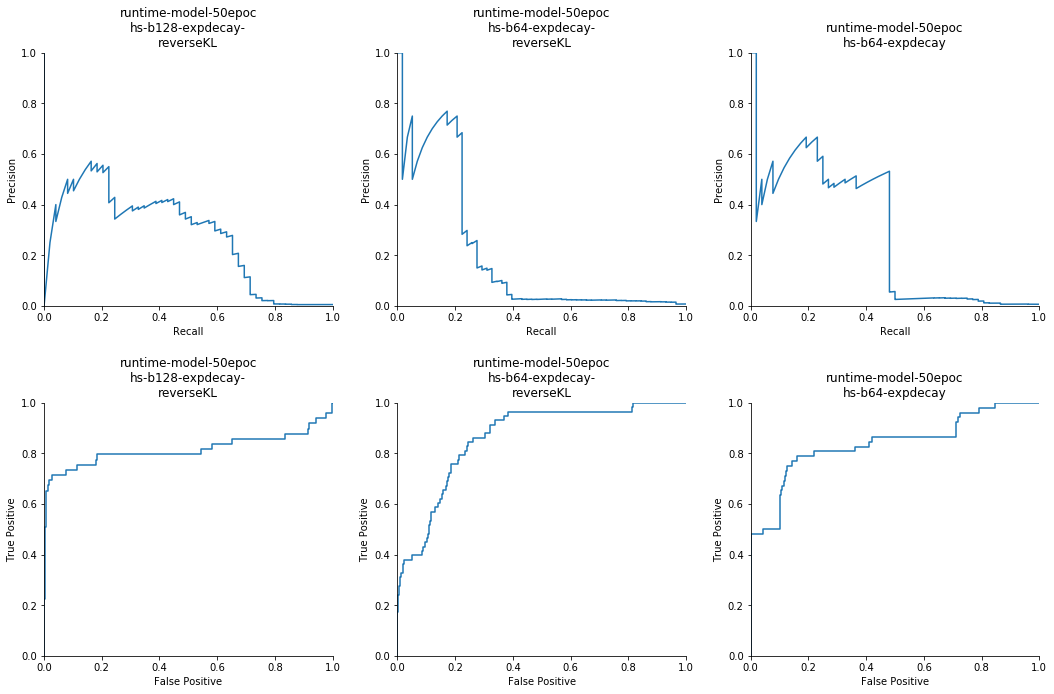

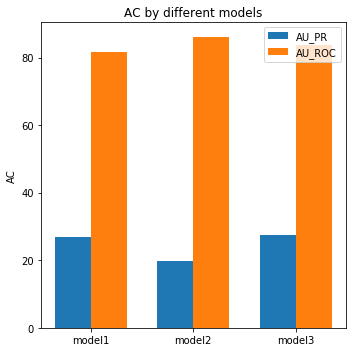

In [19]:
aupr_list, auroc_list, class_dist = plot_pr_roc_curve_misclassify('eval', 'confidence')
plot_aupr_auroc(aupr_list, auroc_list)

[[  49 9951]
 [  58 9942]
 [  52 9948]]


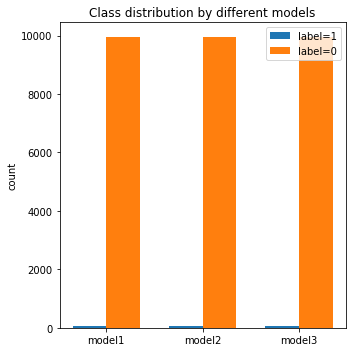

In [28]:
class_dist = np.asarray(class_dist)
print(class_dist)
x = np.arange(len(models)) 
width = 0.35

rcParams['figure.figsize'] = 5, 5
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class_dist[:,0], width, label='label=1')
rects2 = ax.bar(x + width/2, class_dist[:,1], width, label='label=0')

ax.set_ylabel('count')
ax.set_title('Class distribution by different models')
ax.set_xticks(x)
ax.set_xticklabels(['model1','model2','model3'])
ax.legend()

fig.tight_layout()
plt.show()

In [6]:
# Model 2 (runtime-model-50epochs-b64-expdecay-reverseKL)' classification accuracy and other results
with open(f'{models[1]}/eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 0.75 
AUPR using confidence: 19.7
AUPR using entropy_of_expected: 16.6
AUPR using expected_entropy: 5.4
AUPR using mutual_information: 18.4
AUPR using EPKL: 6.6
AUPR using differential_entropy: 4.3
AUROC using confidence: 86.1
AUROC using entropy_of_expected: 85.3
AUROC using expected_entropy: 83.4
AUROC using mutual_information: 61.2
AUROC using EPKL: 28.4
AUROC using differential_entropy: 82.3
ECE: 51.59
MCE: 62.03
Rejection Ratio using confidence: 71.7
Rejection Ratio using entropy_of_expected: 70.1
Rejection Ratio using expected_entropy: 66.2
Rejection Ratio using mutual_information: 21.0
Rejection Ratio using EPKL: -45.7
Rejection Ratio using differential_entropy: 64.1



## FGSM Attack on confidence - train data vs test data

In [3]:
epsilon = "5"
out_dir=model_dir+"/fgsm-attack-8000images-successrate"
epsilons = [0.1,0.2,0.3,0.4]
attack_images=8000 # number of successfully classified images that need to be distorted/perturbed

In [4]:
epsilonlist = " ".join(map(lambda x: str(x),epsilons))
cmd = f"python ./adversarial/confidence_fgsm_attack.py --batch_size {batch_size} --gpu -1 --epsilon {epsilonlist} --attack_images {attack_images} --model_dir {model_dir} --n_channels {num_channels} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python ./adversarial/confidence_fgsm_attack.py --batch_size 64 --gpu -1 --epsilon 0.1 0.2 0.3 0.4 --attack_images 8000 --model_dir runtime-model-50epochs-b64-expdecay-reverseKL --n_channels 1 ./runtime-data MNIST runtime-model-50epochs-b64-expdecay-reverseKL/fgsm-attack-8000images-successrate


In [5]:
os.system(cmd)

0

In [6]:
def plot_adv_samples(out_dir, epsilon):
    probs = np.loadtxt(f"{out_dir}/e{epsilon}-attack/probs.txt")
    labels = np.loadtxt(f"{out_dir}/e{epsilon}-attack/labels.txt")
    preds = np.argmax(probs, axis=1)
    # misclassified samples - org, adversary
    misclassified = np.argwhere(np.asarray(preds != labels, dtype=np.int32) == 1)
    print(misclassified.size)
    rows = int(np.sqrt(misclassified.size))
    figure, axes = plt.subplots(nrows = rows+2,ncols=rows, figsize=(15,15))
    for i, index in enumerate(misclassified):
        index = index[0]
        # print(f"Label: {labels[index]}, Prediction: {preds[index]}")
        ri = int(i/rows)
        ci = int(i%rows)
        axis = axes[ri][ci]
        img = Image.open(f"{out_dir}/e{epsilon}-attack/{index}.png")
        axis.set_title(f"{int(labels[index])}->{preds[index]}")
        axis.imshow(img, cmap="gray")

    figure.tight_layout()
    plt.show()

130


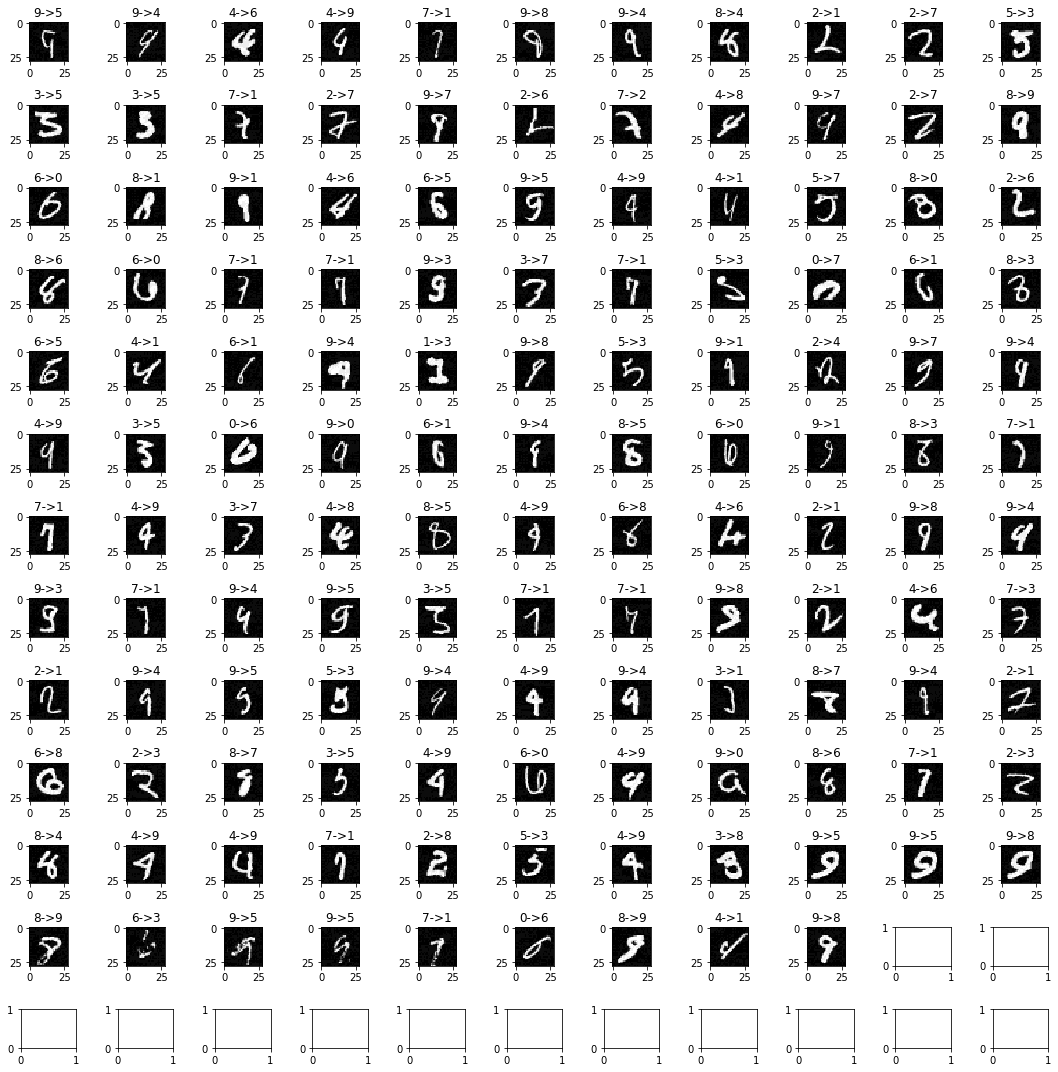

In [10]:
plot_adv_samples(model_dir+"/fgsm-attack-8000images-successrate", 0.1)

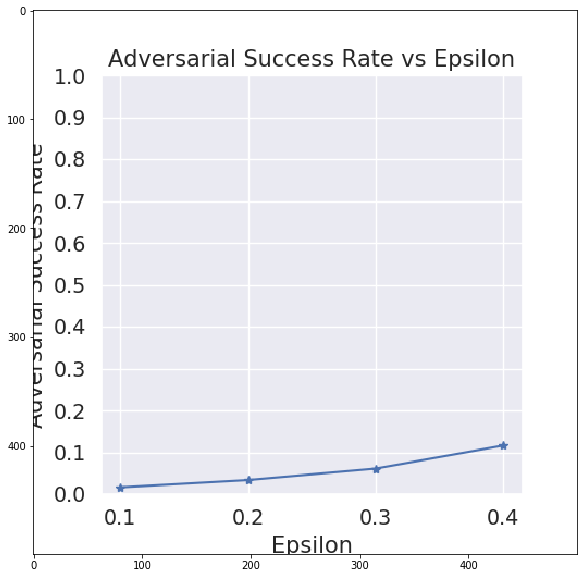

In [19]:
# sample epsilon curve
img = Image.open(f"{out_dir}/epsilon-curve.png")
plt.figure(figsize = (10,10))
plt.imshow(img)